# Which phone features most significantly influence its price?

## Introduction (250)

People use phones daily, and scholars argue that these devices evolved from luxurious items into necessities over the past years (Tanveer et al.). We use them for "calling and sending messages, capturing pictures, accessing the internet, playing games, socializing, and downloading applications." They turned from mere communication tools into daily "multimedia machines" (Tanveer et al.).

Nevertheless, buying new phones can be challenging and frustrating due to the flood of features they offer (Kobie). To escape this tough choice, consumers usually consider only the advertised characteristics of the device without inquiring whether the phone price corresponds to them (K. Srujan Raju et al. 773). Hence, they are likely to make an uninformed decision and overpay.

Therefore, it is essential to create a **regression model that would predict a phone's market price given the device's set of characteristics**. It would help people evaluate whether the phone's proposed price aligns with the competition and is worth paying. 

However, our analysis assumes that the consumer does not have brand loyalty. If they do, our model becomes irrelevant to them because they are willing to pay a higher price without considering a cheaper substitution.

Thus, we want our model to help open-minded consumers quickly yet critically evaluate a phone's price tag and make a rational purchasing decision without being misled by advertising.

## Data set and Methods (300)

We use a data set containing specifications and prices for **1321** unique phone models. The researchers collected the observations via scraping [gadgets360.com](https://www.gadgets360.com/mobiles/best-phones) - an Indian tech news website - and published the [data set](https://www.kaggle.com/datasets/pratikgarai/mobile-phone-specifications-and-prices) in **2022** (Garai). Therefore, the data for our study is reliable and reasonably recent.

Here's the list of variables we consider in our analysis. We rename them from the original data set, derive `resolution` from another two variables, and convert `price` from Indian Rupee to US Dollar to ease the investigation.

| Variable Name  | Description                                                 |
| -------------- | ----------------------------------------------------------- |
| `price`        | Phone price in USD                                          |
| `battery`      | Battery capacity in mAh                                     |
| `screen_size`  | Screen Size in Inches across opposite corners               |
| `resolution`   | The resolution of the phone: (width $\times$ height) / 1000 |
| `processor`    | Number of processor cores                                   |
| `ram`          | RAM available in phone in GB                                |
| `storage`      | Internal Storage of phone in GB                             |
| `rear_camera`  | Resolution of rear camera in MP (0 if unavailable)          |
| `front_camera` | Resolution of front camera in MP (0 if unavailable)         |
| `num_of_sims`  | Number of SIM card slots in phone                           |

We plan to create several linear regression models and assess their performance to choose the best one for this data. Specifically, we'll perform these steps:

#### 1. Preliminary Analysis:
- Read and wrangle the data
- Calculate summary statistics and visualize the association between `price` and other variables

#### 2. Creation of the Models:
- Split the data into testing and training sets, **70% being the training set**
- Deal with possible **multicollinearity** between the input variables by:
    - Using **Variance Inflation Factor (VIF)** to detect it
    - Dropping highly correlated variables if multicollinearity is present
- Build these **Ordinary Least Squares (OLS)** models:
    - **Multiple Linear Regression (MLR) full model** using all input variables
    - **Reduced MLR model** using the variables chosen by a **stepwise forward variable selection** algorithm
    - **Simple Linear Regression (SLR) model** using the most significant variable from the stepwise variable selection
- Build a **Least Absolute Shrinkage and Selection Operator (LASSO)** regression model
    
    
#### 3. Evaluation of the Models:
- Assess the models' performance using **Mean Squared Error (MSE)**

## Preliminary Analysis (150)

Here's the code for performing the first part from the list above.

In [1]:
# Installing missing packages
# https://stackoverflow.com/a/4090208/18184038
package_list <- "psych"
to_install <- package_list[!(package_list %in% installed.packages()[, "Package"])]
if (length(to_install)) install.packages(to_install)

In [30]:
options(jupyter.plot_mimetypes = "image/png")

library(tidyverse)
library(psych)
library(GGally)
library(broom)
library(car)
library(leaps)
library(mltools)
library(glmnet)
library(grid)
library(gridExtra)

set.seed(7)

# Font size for the plots
font_size <- 22

# Reading the data set from the web
url <- "https://raw.githubusercontent.com/Ihor16/stat-301-project/main/data/specs.csv"
data_raw <- read.csv(url) %>%
  as_tibble()

# Previewing the raw data set
data_raw %>%
  head(3)

X,Name,Brand,Model,Battery.capacity..mAh.,Screen.size..inches.,Touchscreen,Resolution.x,Resolution.y,Processor,⋯,Rear.camera,Front.camera,Operating.system,Wi.Fi,Bluetooth,GPS,Number.of.SIMs,X3G,X4G..LTE,Price
<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>
0,OnePlus 7T Pro McLaren Edition,OnePlus,7T Pro McLaren Edition,4085,6.67,Yes,1440,3120,8,⋯,48,16,Android,Yes,Yes,Yes,2,Yes,Yes,58998
1,Realme X2 Pro,Realme,X2 Pro,4000,6.50,Yes,1080,2400,8,⋯,64,16,Android,Yes,Yes,Yes,2,Yes,Yes,27999
2,iPhone 11 Pro Max,Apple,iPhone 11 Pro Max,3969,6.50,Yes,1242,2688,6,⋯,12,12,iOS,Yes,Yes,Yes,2,Yes,Yes,106900


In [3]:
# Conversion rate from INR to USD
# https://www.forbes.com/advisor/money-transfer/currency-converter/inr-usd/
rate <- 0.012282

# Renaming the variables and creating a derived variable for `resolution`
phone_data <- data_raw %>%
  select_if(is.numeric) %>%
  select(-X) %>%
  rename(
    battery = "Battery.capacity..mAh.",
    screen_size = "Screen.size..inches.",
    resolution_x = "Resolution.x",
    resolution_y = "Resolution.y",
    processor = "Processor",
    ram = "RAM..MB.",
    storage = "Internal.storage..GB.",
    rear_camera = "Rear.camera",
    front_camera = "Front.camera",
    num_of_sims = "Number.of.SIMs",
    price = "Price"
  ) %>%
  mutate(
    price = price * rate,
    resolution = (resolution_x * resolution_y) / 1000,
    ram = ram / 1000
  ) %>%
  relocate(resolution, .before = resolution_x) %>%
  select(-c(resolution_x, resolution_y)) %>%
  drop_na() %>%
  select(price, everything())

# Previewing the wrangled data set
phone_data %>%
  head()

price,battery,screen_size,resolution,processor,ram,storage,rear_camera,front_camera,num_of_sims
<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
724.6134,4085,6.67,4492.800,8,12,256,48,16,2
343.8837,4000,6.50,2592.000,8,6,64,64,16,2
1312.9458,3969,6.50,3338.496,6,4,64,12,12,2
772.5378,3110,6.10,1483.776,6,4,64,12,12,2
613.9772,4000,6.40,2527.200,8,6,128,12,32,1
429.0103,3800,6.55,2592.000,8,8,128,48,16,2


In [4]:
# Calculating summary statistics for the data set
phone_data %>%
  describe() %>%
  select(min, mean, median, max, sd)

,min,mean,median,max,sd
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
price,6.067308,140.823270,85.96172,2149.227,170.1977791
battery,1010.000000,2938.489330,3000.00000,6000.000,873.5141331
screen_size,2.400000,5.291310,5.20000,7.300,0.6713566
resolution,76.800000,1348.761263,921.60000,8294.400,954.7353441
processor,1.000000,5.551141,4.00000,10.000,2.1965624
ram,0.064000,2.488778,2.00000,12.000,1.6644404
storage,0.064000,30.654864,16.00000,512.000,36.9502412
rear_camera,0.000000,12.070199,12.20000,108.000,8.9483374
front_camera,0.000000,7.037969,5.00000,48.000,6.2954481


Scholars argue that `ram`, `storage`, and `resolution` are the most significant factors influencing a phone's price (Listianingrum et al.). We can check if our data reflects this by finding the correlation of each numerical variables with `price`.

In [5]:
# Calculating correlation between `price` and every other variable
# https://stackoverflow.com/a/45892364/18184038
phone_data_corr <- cor(phone_data[-1], phone_data$price) %>%
  as.data.frame() %>%
  rename(correlation = V1)

# Printing the correlations for each variable in descending order
phone_data_corr %>%
  arrange(desc(correlation))

,correlation
,<dbl>
storage,0.6440791
ram,0.6134463
resolution,0.5934752
screen_size,0.4024624
rear_camera,0.3791199
front_camera,0.3106717
processor,0.3024918
battery,0.2975252
num_of_sims,-0.1624911


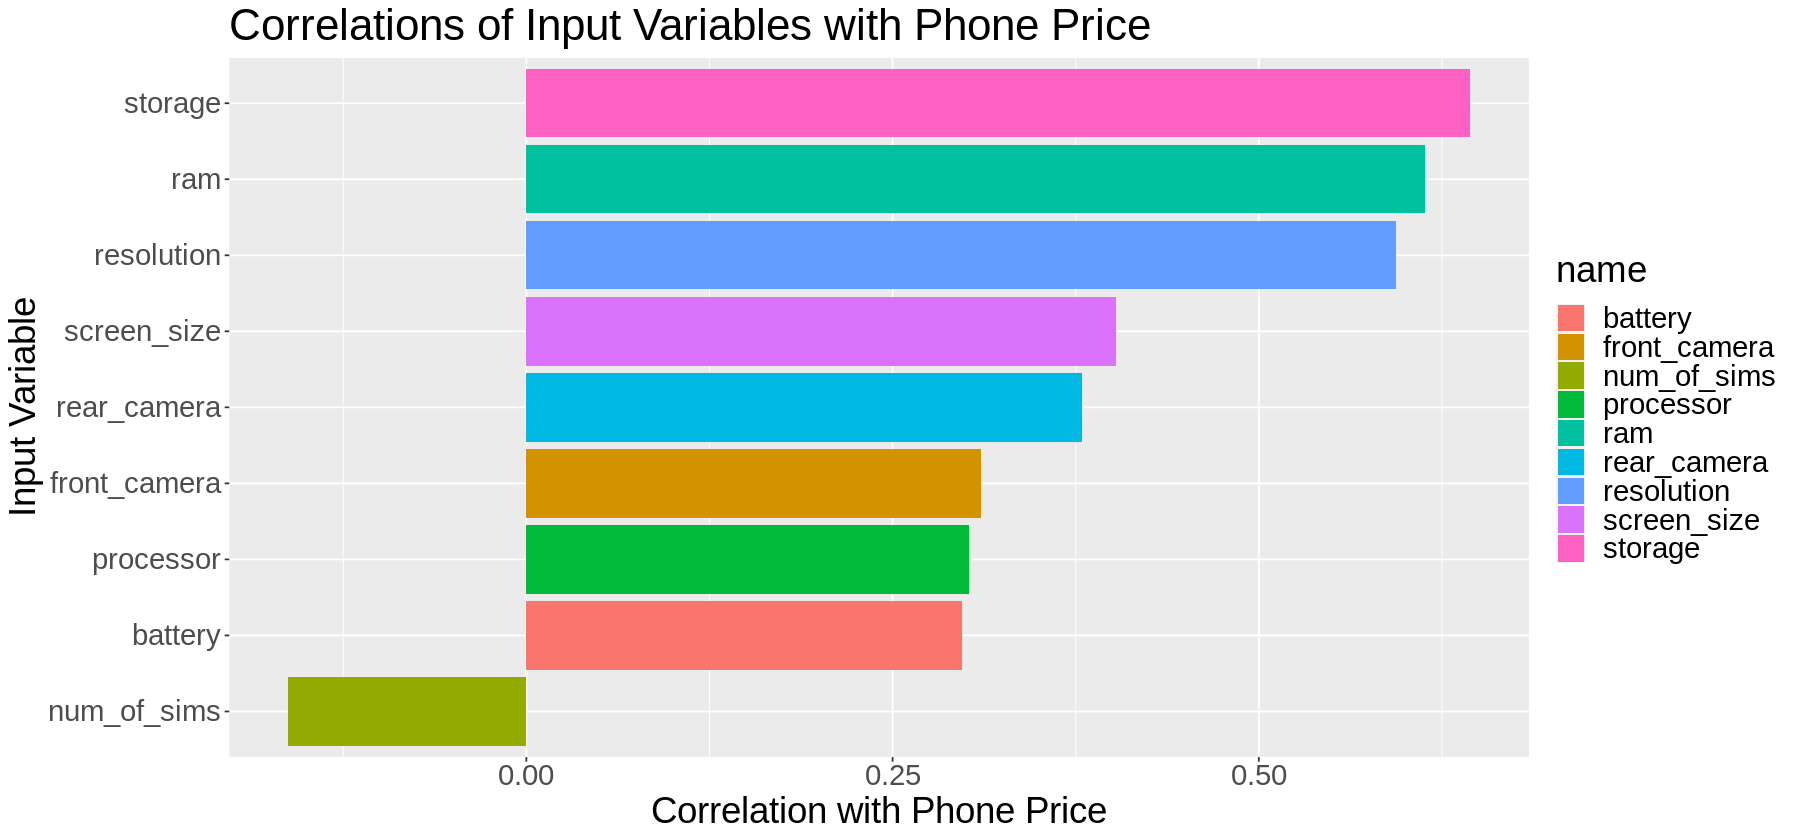

In [6]:
options(repr.plot.width = 15, repr.plot.height = 7)

# Plotting the distribution of calculated correlation coefficients
tibble(
  correlation = phone_data_corr$correlation,
  name = phone_data[-1] %>% colnames()
) %>%
  ggplot(aes(x = reorder(name, correlation), y = correlation, fill = name)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Correlations of Input Variables with Phone Price",
    x = "Input Variable",
    y = "Correlation with Phone Price"
  ) +
  theme(
    text = element_text(size = font_size)
  ) +
  coord_flip()

The data shows that these variables are indeed the top 3 ones correlated with `price`, so the initial analysis of the data corresponds to scholarly claims, and we expect these variables to be present in our best predictive model.

However, the correlation coefficients for these variables are below 0.7. Therefore, we need to evaluate the linear regression assumptions and build the prediction models to see whether this data set is suitable for predicting `price` via linear regression.

## Analysis (900 / 1000)

#### Splitting the Data Set

Before conducting the analysis, we split the wrangled data set into training and testing sets such that the training one contains 70% of the observations. This **holdout method** allows us to perform further analysis without touching the testing set, which we use as the new data while evaluating our models.

In [7]:
# Adding `ID` column to the full data set
phone_data$ID <- rownames(phone_data)

# (1) Shuffling the full data set
# (2) Selecting 70% of the observations
# (3) Assigning those to the training data set
phone_training <- phone_data %>%
  sample_n(size = nrow(phone_data) * 0.7)

# Assigning the rest 30% of the observations to the testing set
phone_testing <- anti_join(
  x = phone_data,
  y = phone_training,
  by = "ID"
)

# Dropping the `ID` column from the created data sets
phone_training <- phone_training %>%
  select(-ID)
phone_testing <- phone_testing %>%
  select(-ID)

# Calculating the number of observations in training and testing sets
tibble(
  data_set = c("training_data", "testing_data"),
  num_of_obs = c(phone_training %>% nrow(), phone_testing %>% nrow())
)

data_set,num_of_obs
<chr>,<int>
training_data,951
testing_data,408


#### Multicollinearity Check

Multicollinearity occurs when there's a high correlation between input variables. A model with it tends to produce invalid predictions because a change in one input variable causes a significant alteration in another (Wu).

Thus, we estimate its presence by creating a **correlation heat map** that visualizes "the strength of relationships between numerical variables" (Kumar).

In [8]:
# Creating a correlation matrix for all numerical variables
phone_data_corr_matrix <- phone_training %>%
  cor() %>%
  as.data.frame() %>%
  rownames_to_column("var1") %>%
  pivot_longer(-var1, names_to = "var2", values_to = "corr")

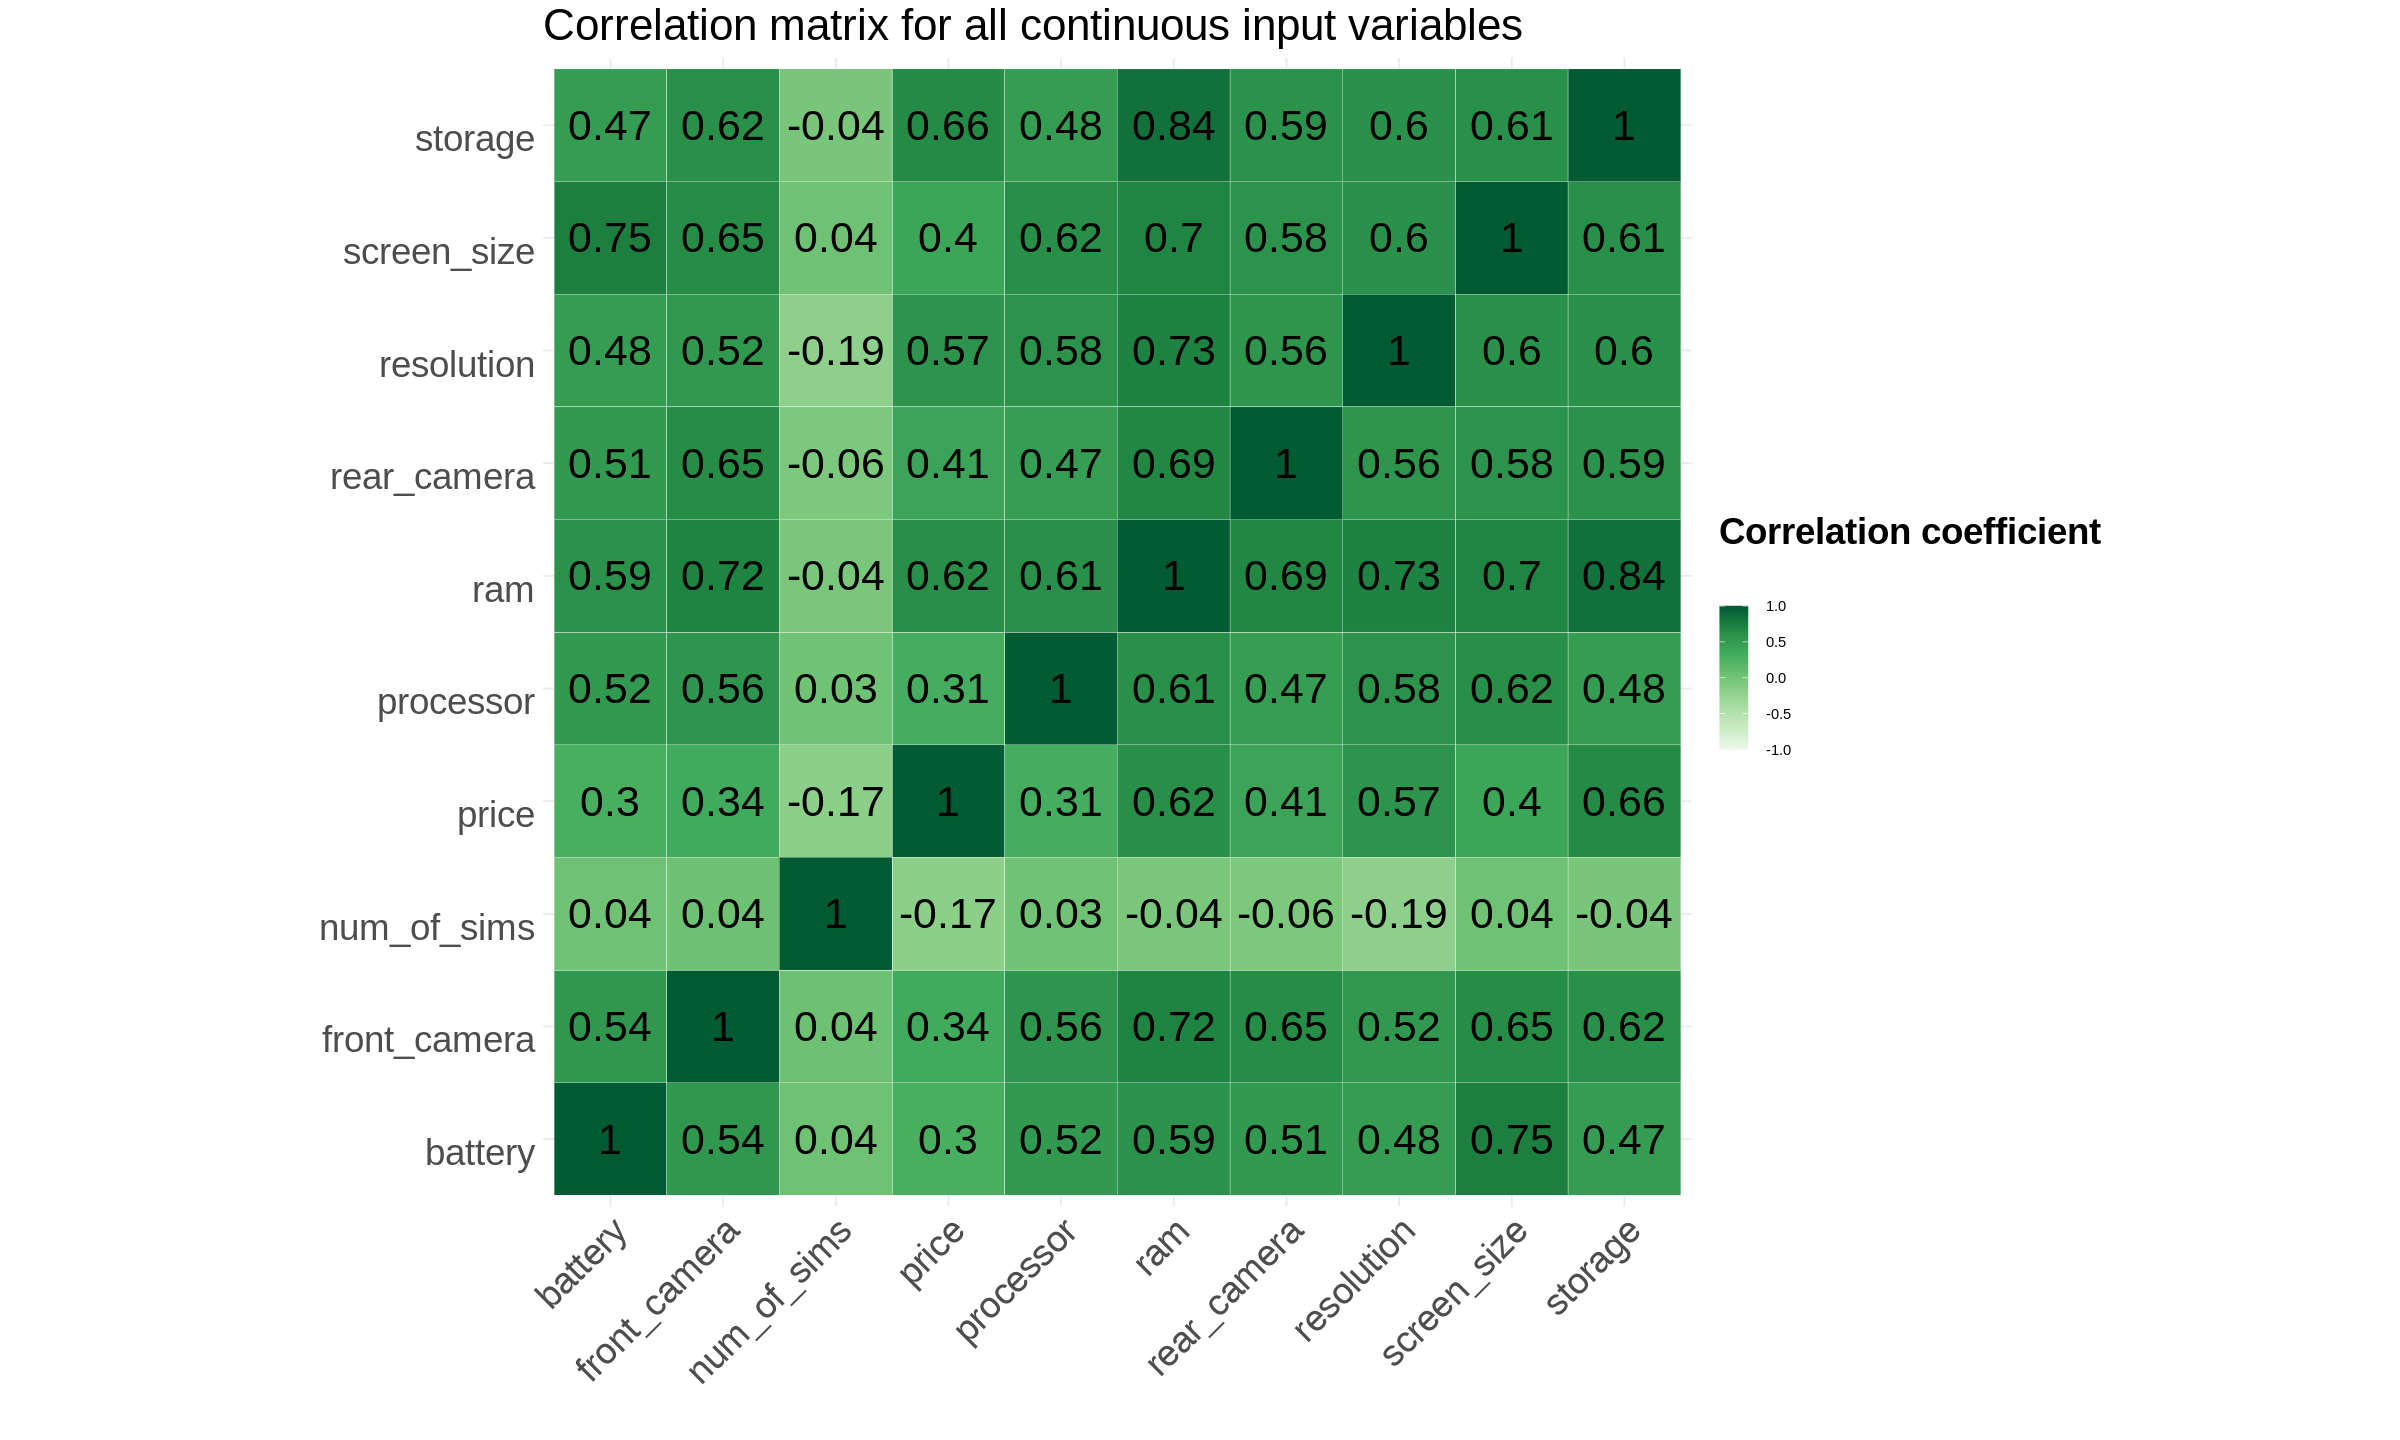

In [9]:
options(repr.plot.width = 20, repr.plot.height = 12)

# Creating the heat map plot
phone_data_corr_matrix %>%
  ggplot(aes(var1, var2)) +
  geom_tile(aes(fill = corr), color = "white") +
  scale_fill_distiller(
    "Correlation coefficient \n",
    palette = "Greens",
    direction = 1,
    limits = c(-1, 1)
  ) +
  theme_minimal() +
  labs(
    title = "Correlation matrix for all continuous input variables",
    x = "", y = "") +
  theme(
    axis.text.x = element_text(
      angle = 45, vjust = 1,
      size = font_size, hjust = 1
    ),
    axis.text.y = element_text(
      vjust = 1,
      size = font_size, hjust = 1
    ),
    legend.title = element_text(size = font_size, face = "bold"),
    title = element_text(size = font_size)
  ) +
  coord_fixed() +
  geom_text(aes(x = var1,
                y = var2,
                label = round(corr, 2)),
            color = "black",
            size = 9
  )

From the plot, we can observe the following variable pairs that have a high correlation, i.e., one with $\geq$ 0.7

| Variable pair               | Correlation value |
| --------------------------- | ----------------- |
| `storage` and `ram`         | 0.85              |
| `screen_size` and `battery` | 0.75              |
| `resolution` and `ram`      | 0.72              |
| `screen_size` and `ram`     | 0.71              |
| `ram` and `front_camera`    | 0.7               |

However, we need to calculate the multicollinearity rigorously to find whether the correlations presented above are problematic. For this, we create a function that:

- Creates a **full MLR** for the given data
- Finds each input variable's **VIF**, which "measures how much the variance of an independent variable is influenced by its correlation with the other independent variables" (Potters)

In [10]:
# (1) Creates MLR for the `data_set` using `price` as a dependant variable and all the rest as input variables
# (2) Calculates the model's VIFs for each input variable and prints the highest 5 of them
calculate_vif <- function(data_set) {
  # Creating a multiple linear regression for `price` using all input variables from the given data set
  mlr <- data_set %>%
    lm(formula = price ~ .)

  # Using Variance Inflation Factor (VIF) to quantify the possible multicollinearity
  mlr %>%
    vif() %>%
    as.data.frame() %>%
    rename(VIF = ".") %>%
    round(3) %>%
    arrange(desc(VIF)) %>%
    head(5)
}

Now we can input the whole training set into this function and find the VIF for each input variable.

In [11]:
# Calculating VIF values using the whole training set
calculate_vif(phone_training)

,VIF
,<dbl>
ram,6.176
storage,3.480
screen_size,3.400
front_camera,2.506
resolution,2.489


We see that VIF values for `ram` and `storage` are the highest ones, which we expected because the correlation between them in the heat map was the highest.

Some scholars argue that VIF values above 10 denote the multicollinearity problem, while others say values above 5 are also problematic (Bock).

Therefore, we try to remedy high VIF values by:
- Removing one or multiple highly correlated input variables
- Adjusting the values of highly correlated variables to change their interpretations

In [12]:
# Calculating VIFs after dropping `ram`
calculate_vif(phone_training %>% select(-ram))

,VIF
,<dbl>
screen_size,3.393
front_camera,2.389
battery,2.318
resolution,2.223
storage,2.114


In [13]:
# Calculating VIFs after dropping `ram` and `storage`
calculate_vif(phone_training %>% select(-c(ram, storage)))

,VIF
,<dbl>
screen_size,3.296
battery,2.316
front_camera,2.262
resolution,2.073
rear_camera,2.045


In [14]:
# Adjusting `storage` column to indicate how much a phone's storage space is above average
phone_data_adjusted_storage <- phone_training %>%
  mutate(storage = storage - 64)

# Calculating VIFs after adjusting `storage`
calculate_vif(phone_data_adjusted_storage)

,VIF
,<dbl>
ram,6.176
storage,3.480
screen_size,3.400
front_camera,2.506
resolution,2.489


Our attempts show that VIFs become lower after we drop the correlated variables. However, scholars consider them significant for predicting a phone's price (Listianingrum et al.), so we keep them as they will give our models more information. Additionally, the highest VIF is still below 10, so we continue our investigation without changing the data.

#### MLR Full Model

Our goal is to create an MLR model using all input variables and then assess its performance by calculating its MSE value.

MLR is a type of linear regression that has multiple input variables, which are used to predict the dependent variable, `price` in our case. Thus, we first fit an additive model using all input variables.

In [15]:
# Building predictive Ordinary Least Squares LR model with all input variables
phone_model_full <- phone_training %>%
  lm(formula = price ~ .)

# Displaying the summary statistics of the full MLR model
phone_model_full %>%
  glance()

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.5278238,0.5233078,119.0692,116.8778,9.843251e-147,9,-5889.884,11801.77,11855.2,13341008,941,951


From the `r.squared` column, which indicates the **coefficient of determination**, we see that the full MLR model explains **52.8%** of the variation of the dependent variable `price`. However, this value does not indicate how well our model predicts out-of-sample observations, so we need to evaluate this metric using the testing set.

In [16]:
# Obtaining out-of-sample predictions for `price` from the testing set using the full model
phone_model_full_test <- predict(
  object = phone_model_full,
  newdata = phone_testing,
)

# Displaying a confidence interval for prediction for the full model
phone_training %>%
  select(ram, storage, screen_size) %>%
  cbind(predict(phone_model_full, interval = "confidence")) %>%
  head(1)

,ram,storage,screen_size,fit,lwr,upr
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,8,4.5,58.97326,45.01038,72.93613


The **95% Confidence Interval for Prediction (CIP)** shown above means that, using the full MLR model, we're 95% certain that the range of **45.01 to 72.94 USD** contains the average price of a phone with `ram` of 1GB, `storage` of 8GB, and `screen_size` of 4.5 inches.

Now, we can use the testing set to evaluate the model by calculating its **MSE**, the average squared difference between the prices in the testing set and the predicted prices stored in `phone_model_full_test`.

In [17]:
# Calculating the MSE value for the full model
phone_model_full_rmse <- rmse(
  preds = phone_model_full_test,
  actuals = phone_testing$price
)

# Storing full model's MSE in the results tibble
phone_rmses <- tibble(
  model = "OLS Full Regression",
  rmse = phone_model_full_rmse
)
phone_rmses

model,rmse
<chr>,<dbl>
OLS Full Regression,114.1929


#### MLR Stepwise Selection Model

Next, we aim to select variables significantly associated with `price` and fit another MLR using those. Using a model with fewer input variables can be beneficial because of these reasons (Rajpurohit):
- The model would contain only relevant variables, so it's less likely to have hidden relationships between its predictors
- Models with fewer input variables tend to perform well on both training and testing sets because such models avoid overfitting
- Small models are easier to interpret for the general public

In our analysis, we perform a stepwise variable selection using a **forward selection** algorithm. This algorithm starts with a model containing one input variable. Then it builds other models by sequentially adding additional variables so that each model is the best for its number of input variables. However, once a variable is selected, it is present in all subsequent models.

The last built model contains `nmax` input variables. We set this value to the maximum possible number of predictors, so the rearmost model is the full MLR from above.

In [18]:
# Performing forward variable selection on the training set
phone_forward_sel <- regsubsets(
  x = price ~ .,
  nvmax = ncol(phone_training) - 1,
  data = phone_training,
  method = "forward"
)
phone_forward_sel

# Storing the summary statistics of the variable selection
phone_forward_sel_summary <- summary(phone_forward_sel)

Subset selection object
Call: regsubsets.formula(x = price ~ ., nvmax = ncol(phone_training) - 
    1, data = phone_training, method = "forward")
9 Variables  (and intercept)
             Forced in Forced out
battery          FALSE      FALSE
screen_size      FALSE      FALSE
resolution       FALSE      FALSE
processor        FALSE      FALSE
ram              FALSE      FALSE
storage          FALSE      FALSE
rear_camera      FALSE      FALSE
front_camera     FALSE      FALSE
num_of_sims      FALSE      FALSE
1 subsets of each size up to 9
Selection Algorithm: forward

Now we have **9 models**, each containing a unique number of variables ranging from 1 to 9. To assess the fit of these regression models, we compare their **Mallows' Cp** values, a metric denoting "how much error is left unexplained by the partial model" (Stephanie).

Thus, the most precise model would have the smallest Cp.

In [19]:
# Storing variable selection metrics
phone_forward_sel_summary_df <- tibble(
  n_input_vars = 1:9,
  cp = phone_forward_sel_summary$cp
)
phone_forward_sel_summary_df

# Saving the row with the smallest Cp value
min_cp <- phone_forward_sel_summary_df %>%
  filter(cp == min(phone_forward_sel_summary_df$cp))
min_cp

n_input_vars,cp
<int>,<dbl>
1,171.392689
2,78.180654
3,37.645136
4,26.702070
5,16.165148
6,8.056393
7,6.576127
8,8.174255
9,10.000000


n_input_vars,cp
<int>,<dbl>
7,6.576127


The minimum Cp value corresponds to the model with **7** variables, but we can also create a scatter plot to visualize the Cp values for each model.

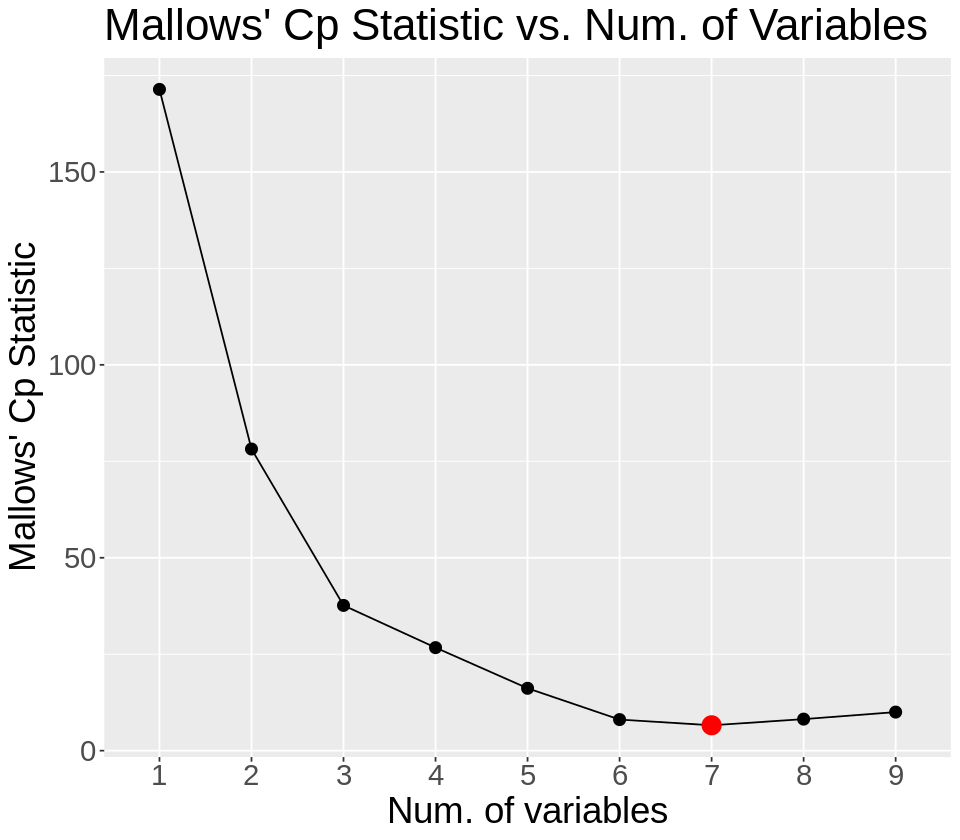

In [20]:
options(repr.plot.width = 8, repr.plot.height = 7)

# Plotting Cp values from the variable selection summary table
phone_forward_sel_summary_df %>%
  ggplot(aes(x = n_input_vars, y = cp)) +
  geom_line() +
  geom_point(aes(x = n_input_vars, y = cp), size = 3) +
  scale_x_discrete(limits = factor(1:9)) +
  geom_point(
    data = min_cp,
    color = "red",
    size = 5
  ) +
  labs(
    title = "Mallows' Cp Statistic vs. Num. of Variables",
    x = "Num. of variables",
    y = "Mallows' Cp Statistic"
  ) +
  theme(text = element_text(size = font_size))

Now we can use `phone_forward_sel_summary` to see which variables were selected and build a reduced MLR using them.

In [21]:
phone_forward_sel_summary

# Building a model using the variables selected by the stepwise forward selection
phone_model_stepwise <- phone_training %>%
  lm(formula = price ~ battery +
    resolution +
    processor +
    ram +
    storage +
    front_camera +
    num_of_sims
  )

phone_model_stepwise %>%
  glance()

Subset selection object
Call: regsubsets.formula(x = price ~ ., nvmax = ncol(phone_training) - 
    1, data = phone_training, method = "forward")
9 Variables  (and intercept)
             Forced in Forced out
battery          FALSE      FALSE
screen_size      FALSE      FALSE
resolution       FALSE      FALSE
processor        FALSE      FALSE
ram              FALSE      FALSE
storage          FALSE      FALSE
rear_camera      FALSE      FALSE
front_camera     FALSE      FALSE
num_of_sims      FALSE      FALSE
1 subsets of each size up to 9
Selection Algorithm: forward
         battery screen_size resolution processor ram storage rear_camera
1  ( 1 ) " "     " "         " "        " "       " " "*"     " "        
2  ( 1 ) " "     " "         "*"        " "       " " "*"     " "        
3  ( 1 ) " "     " "         "*"        " "       " " "*"     " "        
4  ( 1 ) " "     " "         "*"        " "       " " "*"     " "        
5  ( 1 ) " "     " "         "*"        " "       "*" "

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.5275347,0.5240275,118.9793,150.4163,8.69457e-149,7,-5890.175,11798.35,11842.07,13349176,943,951


From the `r.squared` column, we obtain the coefficient of determination of **52.8%**, the same as for the full MLR. Now, we can build and interpret a CIP from this model.

In [22]:
# Obtaining out-of-sample predictions for `price` from the testing set using the stepwise reduced model
phone_model_stepwise_test <- predict(
  object = phone_model_stepwise,
  newdata = phone_testing
)

# Displaying a confidence interval for prediction for the stepwise reduced model
phone_training %>%
  select(ram, storage, screen_size) %>%
  cbind(predict(phone_model_stepwise,
                interval = "confidence",
                level = 0.95)) %>%
  head(1)

,ram,storage,screen_size,fit,lwr,upr
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,8,4.5,58.95602,45.12597,72.78607


The CIP shows that using this model, we're 95% certain that the range of **45.13 to 72.79 USD** contains the average phone price with the presented characteristics. This CIP is similar to the one from MLR, which hints that performing the variable selection was ineffective. 

However, we can evaluate the reduced model's performance and check if it's also close to that of the full MLR.

In [23]:
# Calculating the MSE value for the stepwise reduced model
phone_model_stepwise_rmse <- rmse(
  preds = phone_model_stepwise_test,
  actuals = phone_testing$price
)

# Adding stepwise reduced model's MSE to the results tibble
phone_rmses <- phone_rmses %>%
  rbind(tibble(
    model = "OLS Stepwise Reduced Regression",
    rmse = phone_model_stepwise_rmse
  )) %>%
  unique()

phone_rmses

model,rmse
<chr>,<dbl>
OLS Full Regression,114.1929
OLS Stepwise Reduced Regression,114.0210


#### LASSO Model

!!! describe the process and benefits

[1] 0.46

,full_model,lasso
,<dbl>,<dbl>
(Intercept),128.617,102.659
battery,-0.009,-0.008
screen_size,-4.390,-0.397
resolution,0.053,0.050
processor,-6.661,-5.427
ram,25.723,21.332
storage,2.198,2.172
rear_camera,-0.386,0.000
front_camera,-4.778,-4.369


model,rmse
<chr>,<dbl>
OLS Full Regression,114.1929
OLS Stepwise Reduced Regression,114.0210
LASSO Regression with min MSE,114.2197


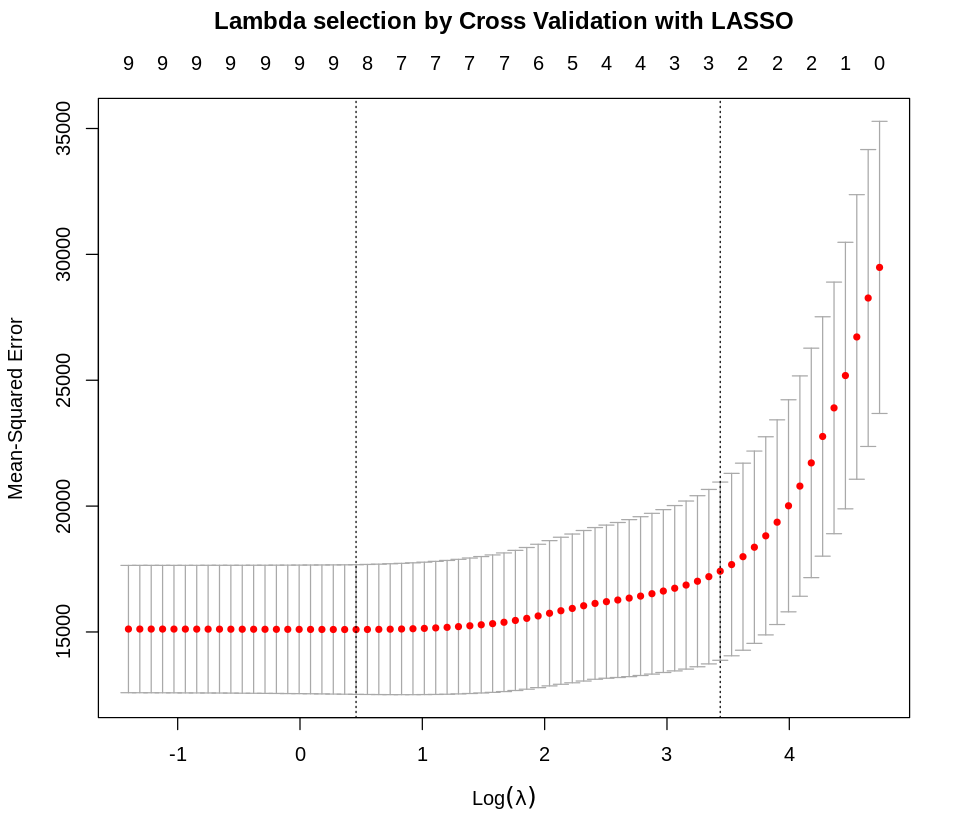

In [24]:
# Creating a matrix of all input variables from the training set
phone_training_matrix_x <- phone_training %>%
  select(-price) %>%
  as.matrix()

# Creating a matrix of responses from the training set
phone_training_matrix_y <- phone_training %>%
  select(price) %>%
  as.matrix()

# Creating a matrix of all input variables from the testing set
phone_testing_matrix_x <- phone_testing %>%
  select(-price) %>%
  as.matrix()

# Creating a matrix of responses from the testing set
phone_testing_matrix_y <- phone_testing %>%
  select(price) %>%
  as.matrix()

# Finding the optimal value of lambda, the penalty parameter
phone_cv_lambda <- cv.glmnet(
  x = phone_training_matrix_x,
  y = phone_training_matrix_y,
  alpha = 1
)

# Plotting the range of lambda values vs. MSE
phone_cv_lambda %>%
  plot(
    main = "Lambda selection by Cross Validation with LASSO\n\n"
  )

# Storing the min value of lambda
phone_lambda_min <- round(phone_cv_lambda$lambda.min, 3)

# Displaying the min value of lambda
round(log(phone_lambda_min), 2)

# Building LASSO model with the min lambda
phone_model_lasso <- glmnet(
  x = phone_training_matrix_x,
  y = phone_training_matrix_y,
  alpha = 1,
  lambda = phone_lambda_min
)

# Comparing coefficients from the full MLR model and LASSO with min lambda
data.frame(
  full_model = coef(phone_model_full),
  lasso = c(phone_model_lasso$a0, as.vector(phone_model_lasso$beta))
) %>%
  round(3)

# Obtaining out-of-sample predictions for `price` from the testing set using the lasso model
phone_model_lasso_test <- predict(
  object = phone_model_lasso,
  newx = phone_testing_matrix_x
)

# Calculating the MSE value for the lasso model
phone_model_lasso_rmse <- rmse(
  preds = phone_model_lasso_test,
  actuals = phone_testing$price
)

# Adding LASSO model's MSE to the results tibble
phone_rmses <- phone_rmses %>%
  rbind(tibble(
    model = "LASSO Regression with min MSE",
    rmse = phone_model_lasso_rmse
  )) %>%
  unique()

phone_rmses %>%
  as.data.frame()

#### SLR Model

!!! choose the input variable and fit the model

## Evaluation (400)

Our models explain 52.8% of the training set's variation, and the MSE for all of them is approximately the same. Therefore, in our analysis, we made multiple crucial mistakes that prevented us from creating effective regression models.

**(1) First**, we did not check for the linearity assumption yet still assumed that our variables are linearly related. However, the scatter plots of `price` vs. each input variable make it evident that most variables are not linearly related to `price`.

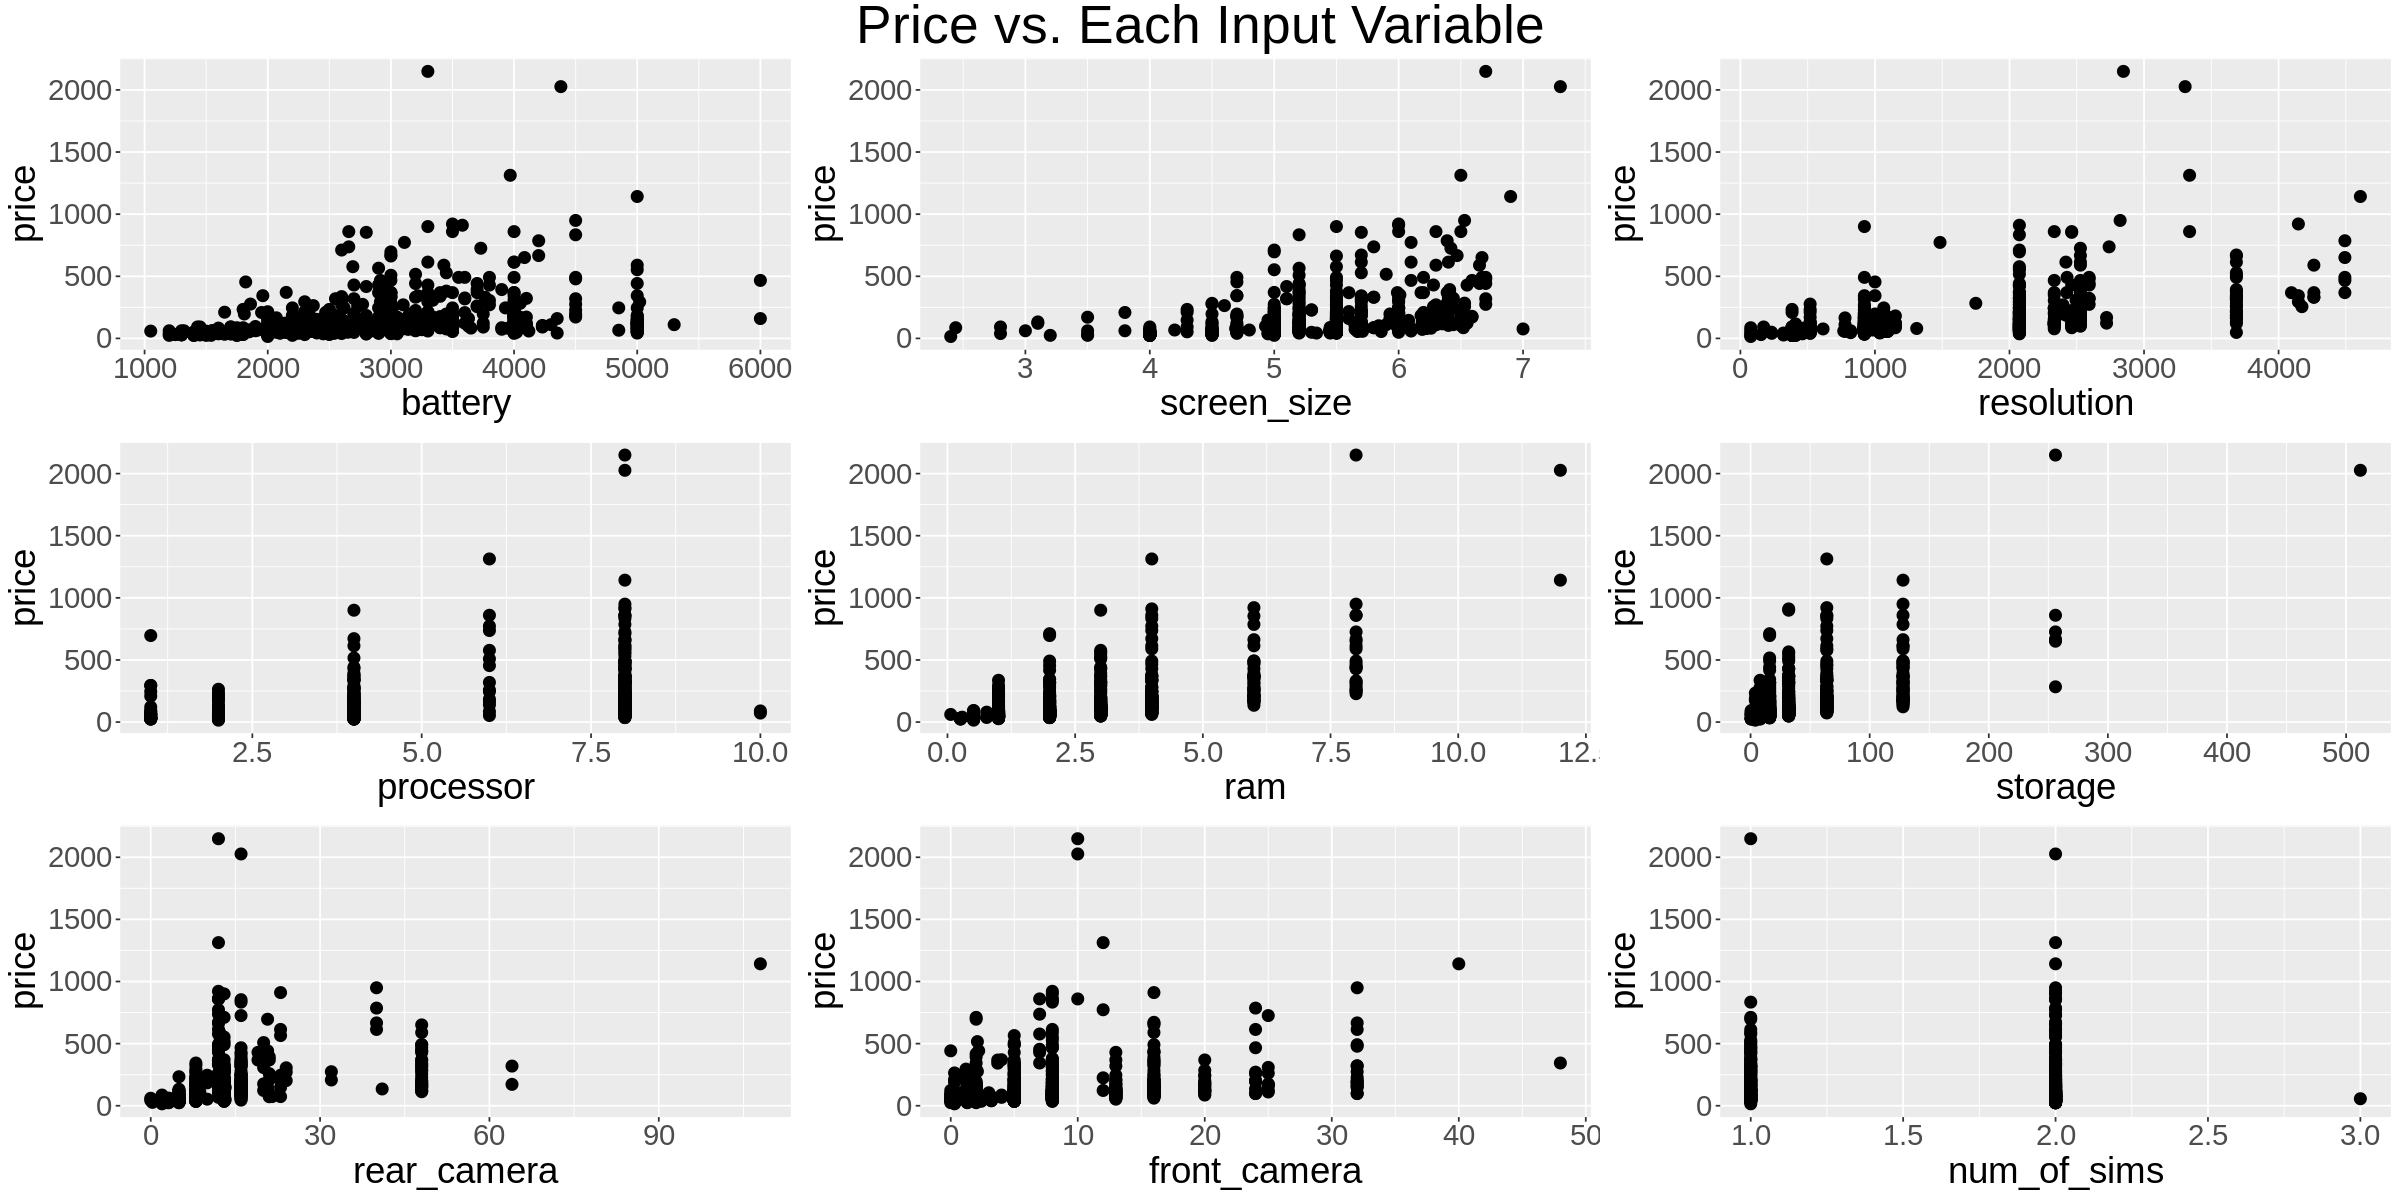

In [81]:
options(repr.plot.width = 20, repr.plot.height = 10)

# Creating scatter plots between all variables
plots <- phone_training %>%
  ggpairs()

# Printing the scatter plots between price and an each input variable
grid.arrange(plots[2, 1] + coord_flip() + geom_point(size = 3) + theme(text = element_text(size = font_size)),
             plots[3, 1] + coord_flip() + geom_point(size = 3) + theme(text = element_text(size = font_size)),
             plots[4, 1] + coord_flip() + geom_point(size = 3) + theme(text = element_text(size = font_size)),
             plots[5, 1] + coord_flip() + geom_point(size = 3) + theme(text = element_text(size = font_size)),
             plots[6, 1] + coord_flip() + geom_point(size = 3) + theme(text = element_text(size = font_size)),
             plots[7, 1] + coord_flip() + geom_point(size = 3) + theme(text = element_text(size = font_size)),
             plots[8, 1] + coord_flip() + geom_point(size = 3) + theme(text = element_text(size = font_size)),
             plots[9, 1] + coord_flip() + geom_point(size = 3) + theme(text = element_text(size = font_size)),
             plots[10, 1] + coord_flip() + geom_point(size = 3) + theme(text = element_text(size = font_size)),
             nrow = 3, ncol = 3,
             top = textGrob("Price vs. Each Input Variable",
                            gp = gpar(fontsize = font_size + 10))
)

Thus, it was wrong to use linear regression for modeling their relationship. Future studies may use other methods to fit a predictive model that better captures the relationship between input variables and `price` in this data to fix this mistake.

**(2) Second**, as the plot above shows, it could be better to treat `processor`, `ram`, `storage`, and `num_of_sims` as categorical variables rather than continuous. This change would involve adjusting the methodology of selecting significant variables: it would be necessary to use F-tests instead of the forward selection algorithm we applied. Therefore, future studies can try this method and compare their findings.

**(3) Third**, we assumed the normality of the residuals for our fitted models. However, their distribution plots below indicate right skewness, which means our models don't explain all trends in the data. One potential remedy that future research can employ is building a model using interaction terms. This addition would cover the cases when, for example, an independent variable `A` influences the `price` differently depending on the values of another independent variable `B` (Interactions in Multiple Linear Regression Basic Ideas).

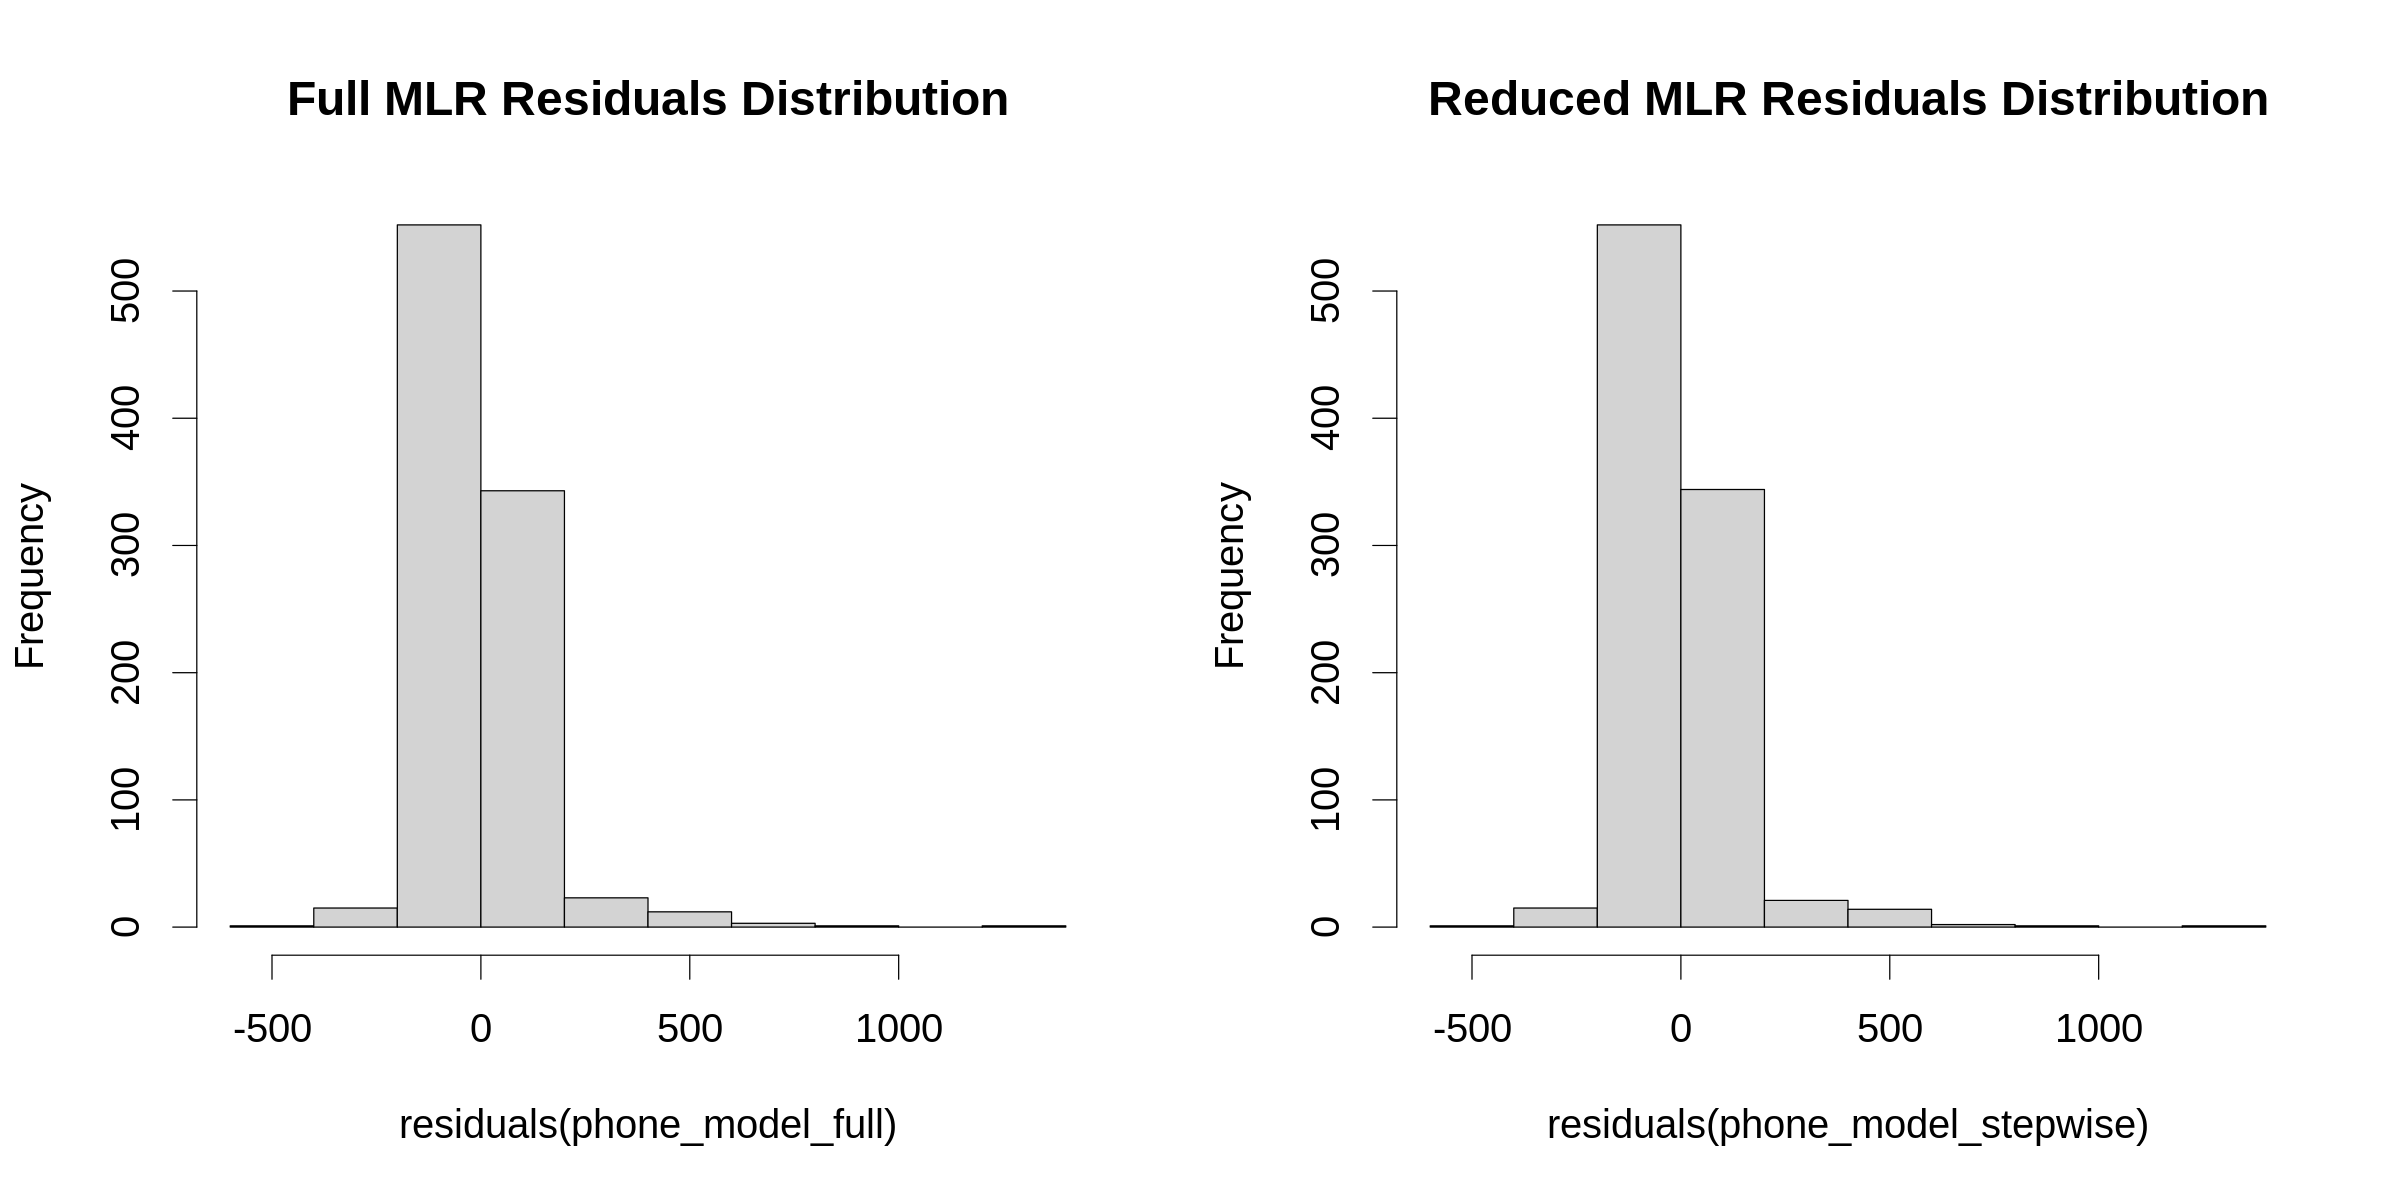

In [82]:
options(repr.plot.width = 20, repr.plot.height = 10)

# Plotting the distributions of residuals for full and reduced MLR models
# https://stackoverflow.com/a/10907452/18184038
par(mfrow = c(1, 2), cex = 2)
hist(residuals(phone_model_full),
     main = "Full MLR Residuals Distribution")
hist(residuals(phone_model_stepwise),
     main = "Reduced MLR Residuals Distribution")

Additionally, there are several limitations of the data set, which prevented our analysis from being successful:

- Even though the data set was published in 2022, it missed variables describing critical features of modern smartphones. For example, the data did not have variables describing screen refresh rate, availability of NFS module, or 5G compatibility, which may influence smartphone prices today. This lack of input variables can be corrected by re-parsing the website and retrieving these new features.

- The data contained smartphone observations from the Indian market, so our study assumed that its prices reflected the global situation. However, it's not always the case. For example, iPhone prices in the US are significantly lower (Hilsenteger). Future studies can fix this limitation by parsing websites from different regions and randomly selecting phones from this international data set.

## Conclusion (200)

## References

“Best Mobile Phones in India | Latest & New Smartphones Price.” *Gadgets 360*, 2020, www.gadgets360.com/mobiles/best-phones. Accessed 3 Dec. 2022.

Bock, Tim. “What Are Variance Inflation Factors (VIFs)? | Displayr.com.” *Displayr*, 6 Apr. 2018, www.displayr.com/variance-inflation-factors-vifs/.

Garai, Pratik. “Mobile Phone Specifications and Prices.” *Www.kaggle.com*, 14 Aug. 2022, www.kaggle.com/datasets/pratikgarai/mobile-phone-specifications-and-prices. Accessed 4 Dec. 2022.

Hilsenteger, Lewis. “IPhone 14 ESIM Controversy Explained.” *Www.youtube.com*, 12 Sept. 2022, www.youtube.com/watch?t=543&v=DLILlKdELEk&feature=youtu.be. Accessed 3 Dec. 2022.

K. Srujan Raju, et al. *Data Engineering and Communication Technology*. Springer, 9 Jan. 2020, p. 773.

Kobie, Nicole. “Why Does Buying a New Phone Have to Be so - ProQuest.” *Www.proquest.com*, Apr. 2017, www.proquest.com/docview/1985885659?accountid=14656&forcedol=true&pq-origsite=summon. Accessed 3 Dec. 2022.

Kumar, Ajitesh. “Correlation Concepts, Matrix & Heatmap Using Seaborn.” *Data Analytics*, 16 Apr. 2022, vitalflux.com/correlation-heatmap-with-seaborn-pandas/#:~:text=with%20each%20other.-.

Listianingrum, T, et al. “Smartphone Hedonic Price Study Based on Online Retail Price in Indonesia.” *Journal of Physics: Conference Series*, vol. 1863, no. 1, 1 Mar. 2021, p. 012032, 10.1088/1742-6596/1863/1/012032. Accessed 1 May 2022.

Potters, Charles. “Variance Inflation Factor (VIF).” *Investopedia*, 26 July 2022, www.investopedia.com/terms/v/variance-inflation-factor.asp#:~:text=Variance%20inflation%20factor%20measures%20how.

Tanveer, Muhammad, et al. “Mobile Phone Buying Decisions among Young Adults: An Empirical Study of Influencing Factors.” *Sustainability*, vol. 13, no. 19, 27 Sept. 2021, p. 10705, 10.3390/su131910705. Accessed 8 Oct. 2021.

Wu, Songhao. “Multi-Collinearity in Regression.” *Medium*, 23 May 2020, towardsdatascience.com/multi-collinearity-in-regression-fe7a2c1467ea.